## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

def get_camera_calibration_points():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('../camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            #cv2.imshow('img',img)
            #cv2.waitKey(500)

    #cv2.destroyAllWindows()
    return (objpoints, imgpoints)





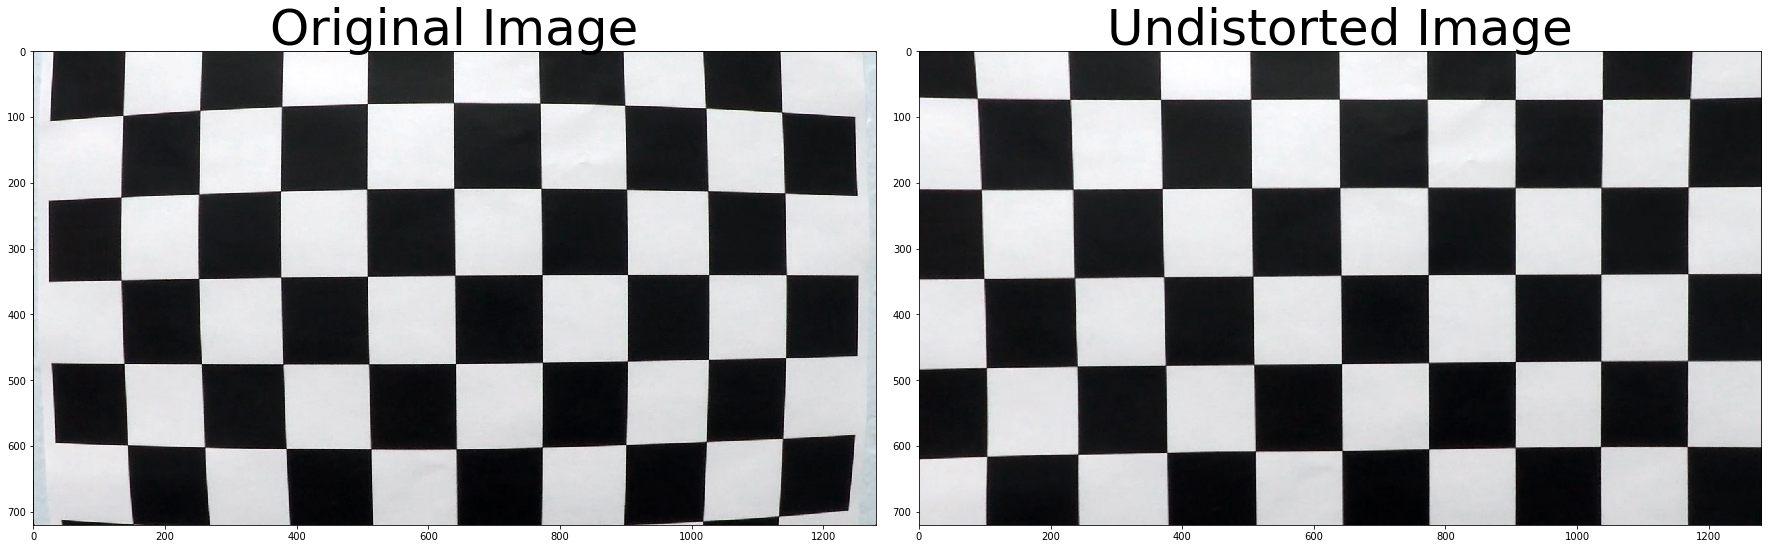

In [2]:
##Undistorting image
img= cv2.imread('../camera_cal/calibration1.jpg')

def undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

(objpoints, imgpoints) = get_camera_calibration_points()
undistorted=undistort(img, objpoints, imgpoints)   
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

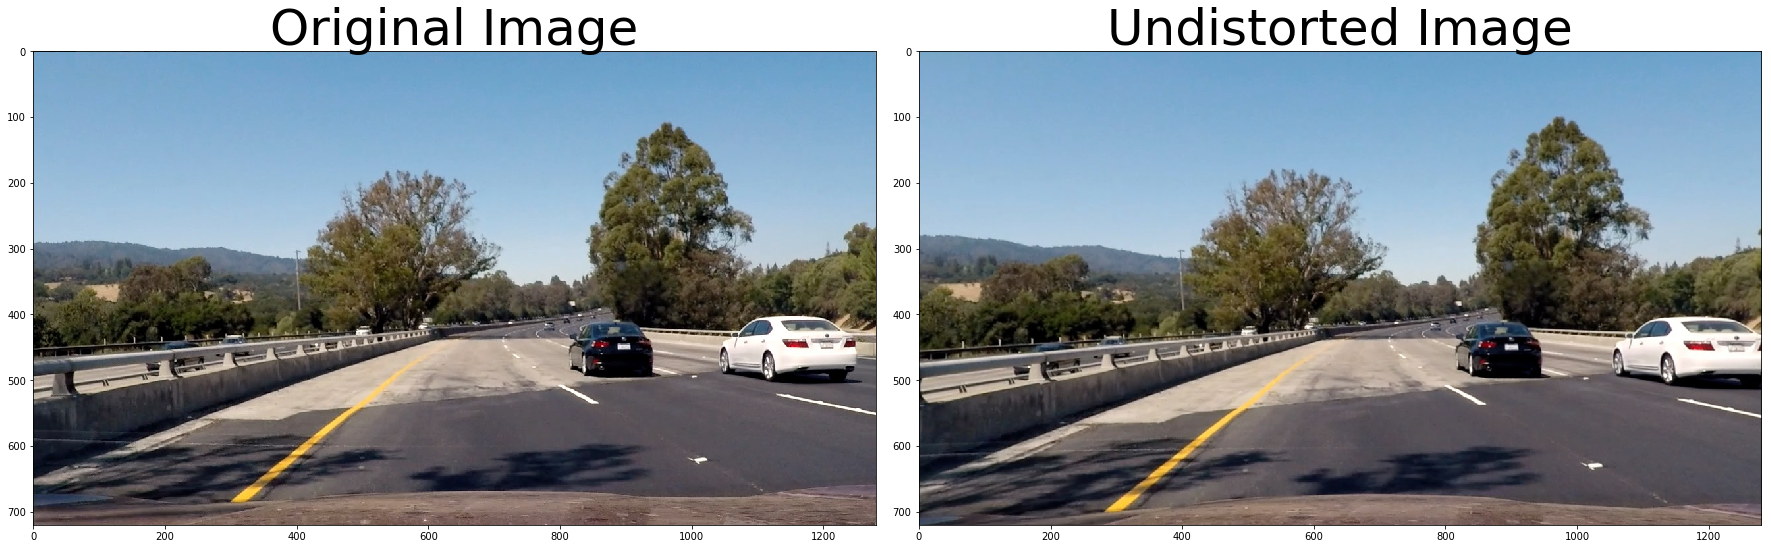

In [3]:
image_name='../test_images/test4.jpg'
img= cv2.imread(image_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undistorted=undistort(img, objpoints, imgpoints)   
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Color & gradient filters

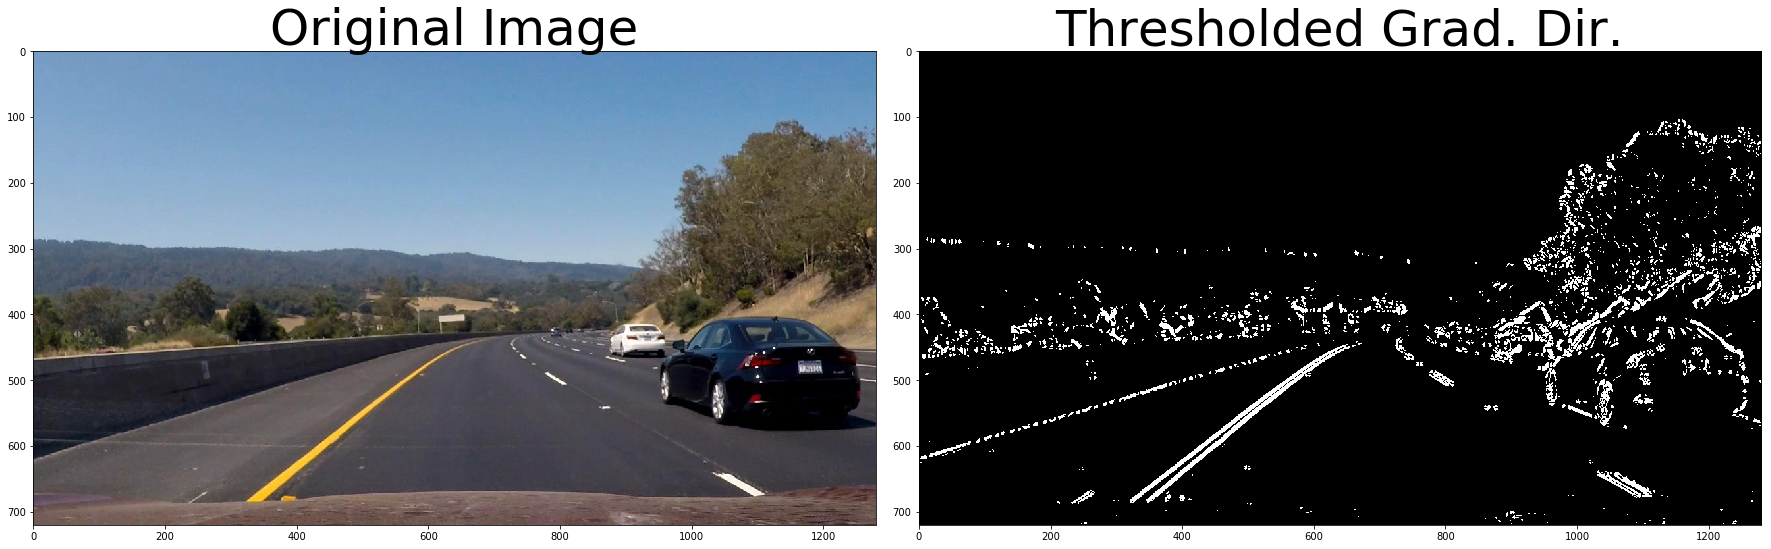

In [43]:
#image_name='../test_images/test4.jpg'
image_name='../test_images/challenge_3.jpg'
#image_name='../test_images/challenge_2.jpg'
#image_name='../test_images/challenge_1.jpg'
image = cv2.imread(image_name) #5
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
## Gradient treshold
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Choose a Sobel kernel size
ksize = 15 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(10, 240))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
#combined[((gradx == 1) & (grady == 1)) | (mag_binary == 1)] = 1

dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.9, 1.1))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


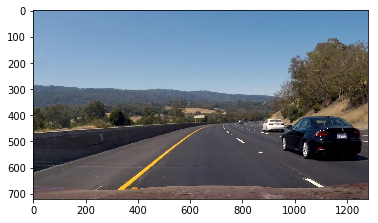

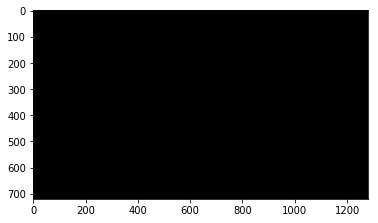

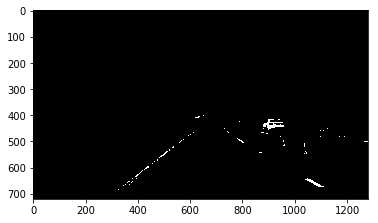

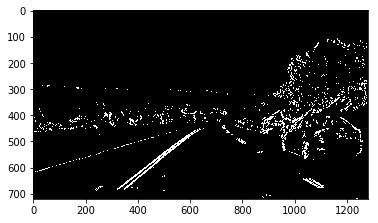

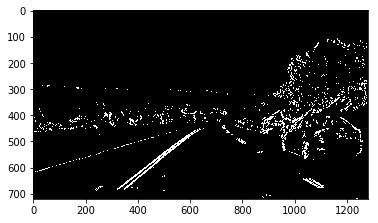

In [44]:
##color thresholds
%matplotlib inline
def hls_select(img, s_thresh=(0, 255), l_thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    l_channel = hls[:,:,1]
    binary_output[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1] & (l_channel > l_thresh[0]) & (l_channel <= l_thresh[1]))] = 1
    return binary_output


def hsv_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hls[:,:,2]
    binary_output = np.zeros_like(v_channel)
    binary_output[(v_channel > thresh[0]) & (v_channel <= thresh[1])] = 1
    return binary_output

def grey_select(img, thresh=(0, 255)):
    grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    binary_output = np.zeros_like(grey)
    binary_output[(grey > thresh[0]) & (grey <= thresh[1])] = 1
    return binary_output

hls_binary = hls_select(image, s_thresh=(170, 255), l_thresh=(50, 255))

grey_binary = grey_select(image, thresh=(200, 255))
combined = np.zeros_like(grey_binary)
#combined[((hls_binary == 1) & (grey_binary == 1))] = 1
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1) & (hls_binary == 1) & (grey_binary == 1))] = 1
plt.imshow(image)
plt.show()
plt.imshow(hls_binary, cmap='gray')
plt.show()
plt.imshow(grey_binary, cmap='gray')
plt.show()
plt.imshow(combined, cmap='gray')
plt.show()

def color_and_gradient_filter(img, ksize = 15):
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(10, 240))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3))
    hls_binary = hls_select(img, s_thresh=(100, 255), l_thresh=(180, 255)) #150
    hsv_binary = hsv_select(img, thresh=(50, 255))
    grey_binary = grey_select(img, thresh=(200, 255))
    combined = np.zeros_like(grey_binary)
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1) & ((hls_binary == 1) | (grey_binary == 1) | (hsv_binary == 1)))] = 1

    combined[((gradx == 1) & (grady == 1)) | (((hls_binary == 1)  & (hsv_binary == 1) )) ] = 1
    return combined 

plt.imshow(color_and_gradient_filter(image), cmap='gray')
plt.show()
combined= color_and_gradient_filter(image)

## Perspective transform

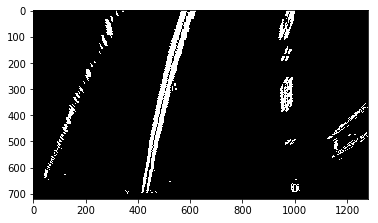

In [45]:
src_points = np.float32([[179, 720], [1140, 720], [740, 460], [550, 460]])
dest_points = np.float32([[350, 720], [977, 720], [977, 0], [350, 0]])

#w=1280
#h = 720
#upper_trapezoid_width =  62
#lower_trapezoid_width = 400
#trapezoid_height      = 215
#trapezoid_dist_bottom =  45


#t_top_left     = (w/2 - upper_trapezoid_width, h - trapezoid_dist_bottom - trapezoid_height)
#t_top_right    = (w/2 + upper_trapezoid_width, h - trapezoid_dist_bottom - trapezoid_height)
#t_bottom_left  = (w/2 - lower_trapezoid_width, h - trapezoid_dist_bottom)
#t_bottom_right = (w/2 + lower_trapezoid_width, h - trapezoid_dist_bottom)
 
#square_size = 400
   
    # s_ for Square
#s_top_left     = (w/2 - square_size/2, 0)
#s_top_right    = (w/2 + square_size/2, 0)
#s_bottom_left  = (w/2 - square_size/2, h)
#s_bottom_right = (w/2 + square_size/2, h)
 
#src = np.float32([t_top_left,
#                      t_top_right,
#                      t_bottom_left,
#                      t_bottom_right])
#dst = np.float32([s_top_left,
#                      s_top_right,
#                      s_bottom_left,
#                      s_bottom_right])
 
src=src_points
dst = dest_points

def warp(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped

def unwarp(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    Minv = cv2.getPerspectiveTransform(dst, src)
    unwarped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    return unwarped

#warped = warp(combined,src_points, dest_points)
warped = warp(combined,src, dst)
plt.imshow(warped,cmap='gray')
plt.show()

## Calculating meter per pixel

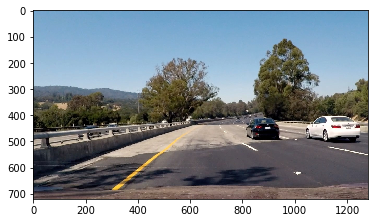

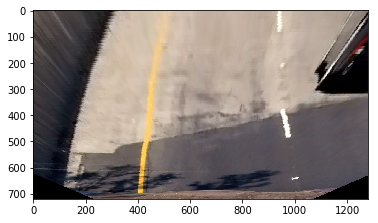

True

In [46]:
image_name='../test_images/test4.jpg'
image_pp = cv2.imread(image_name) #5
image_pp = cv2.cvtColor(image_pp, cv2.COLOR_BGR2RGB)
warped_pp = warp(image_pp, src, dst)
plt.imshow(image_pp)
plt.show()
plt.imshow(warped_pp)
plt.show()
cv2.imwrite('../output_images/test_4_warped.jpg',warped_pp)

## Find sliding windows

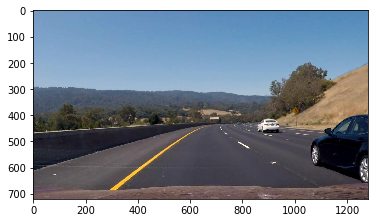

In [47]:
#image_name='../test_images/test4.jpg'
#image_name='../test_images/challenge_3.jpg'
#image_name='../test_images/challenge_2.jpg'
image_name='../test_images/challenge_1.jpg'
image = cv2.imread(image_name) #5
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [48]:
class WindowFinder:
    
    def __init__(self, window_width=50, window_height=80, margin=100, meters_pp_y = 1, meters_pp_x= 1, smooth_factor = 15) :
        self.centers = []
        self.window_width = window_width
        self.window_height = window_height
        self.margin = margin
        self.meters_pp_y=meters_pp_y
        self.meters_pp_x=meters_pp_x
        self.smooth_factor=smooth_factor

    def find_window_centroids(self, image):
        window_width = self.window_width
        window_height= self.window_height
        margin= self.margin
        window_centroids = [] # Store the (left,right) window centroid positions per level
        window = np.ones(window_width) # Create our window template that we will use for convolutions

        # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
        # and then np.convolve the vertical image slice with the window template 

        # Sum quarter bottom of image to get slice, could use a different ratio
        #l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
        #l_sum = np.sum(image[int(image.shape[0]*3./4):,:int(image.shape[1]/2)], axis=0)
        l_sum = np.sum(image[int(image.shape[0]*1./2):,:int(image.shape[1]/2)], axis=0)
        l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
        #r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
        r_sum = np.sum(image[int(image.shape[0]*1./2):,int(image.shape[1]/2):], axis=0)
        r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)

        # Add what we found for the first layer
        window_centroids.append((l_center,r_center))

        # Go through each layer looking for max pixel locations
        for level in range(1,(int)(image.shape[0]/window_height)):
            # convolve the window into the vertical slice of the image
            image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
            conv_signal = np.convolve(window, image_layer)
            # Find the best left centroid by using past left center as a reference
            # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
            offset = window_width/2
            l_min_index = int(max(l_center+offset-margin,0))
            l_max_index = int(min(l_center+offset+margin,image.shape[1]))
            l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
            # Find the best right centroid by using past right center as a reference
            r_min_index = int(max(r_center+offset-margin,0))
            r_max_index = int(min(r_center+offset+margin,image.shape[1]))
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
            # Add what we found for that layer
            window_centroids.append((l_center,r_center))

        self.centers.append(window_centroids)
        return np.average(self.centers[-self.smooth_factor:], axis=0)



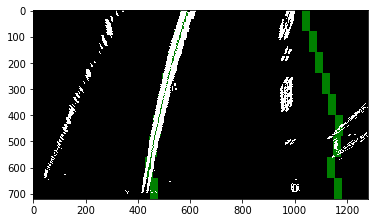

In [49]:
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

#find centers of the sliding windows
window_width=30
window_height=80
margin=25
meters_pp_y = 3/107#10/720 
meters_pp_x = 3/657#4/380
curve_centers=WindowFinder(window_width=window_width, window_height=window_height, margin=margin,meters_pp_y=meters_pp_y,meters_pp_x=meters_pp_x )
window_centroids= curve_centers.find_window_centroids(image=warped)

#points to draw the windows
l_points = np.zeros_like(warped)
r_points = np.zeros_like(warped)

#points to fit to polinom
leftx= []
rightx= []

# Go through each level and draw the windows 	
for level in range(0,len(window_centroids)):
    # Window_mask is a function to draw window areas
    
    #adding center value for drawing
    leftx.append(window_centroids[level][0])
    rightx.append(window_centroids[level][1])
    l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
    r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
    # Add graphic points from window mask here to total pixels found 
    l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
    r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255


# Draw the results

template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
zero_channel = np.zeros_like(template) # create a zero color channel
template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
result = cv2.addWeighted(warpage, 1, template, 0.5, 0.0)
def draw_results(r_points, l_points, warped)
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
    result = cv2.addWeighted(warpage, 1, template, 0.5, 0.0)
    return result

plt.imshow(result)
plt.show()

def get_window_centers(warped_image):
    window_width=30
    window_height=80
    margin=25
    meters_pp_y = 3/105#10/720
    meters_pp_x = 4/380
    curve_centers=WindowFinder(window_width=window_width, window_height=window_height, margin=margin,meters_pp_y=meters_pp_y,meters_pp_x=meters_pp_x )
    window_centroids= curve_centers.find_window_centroids(image=warped_image)

    #points to fit to polinom
    leftx= []
    rightx= []

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas

        #adding center value for drawing
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])
    return (leftx, rightx, curve_centers)





In [ ]:
image_name='../test_images/challenge_3.jpg'
#image_name='../test_images/challenge_2.jpg'
#image_name='../test_images/challenge_1.jpg'
image = cv2.imread(image_name) #5
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

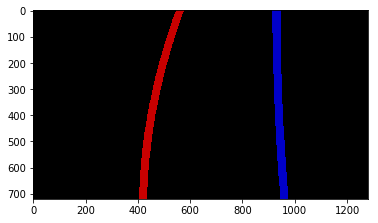

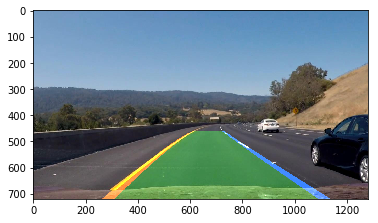

[  1.39018818e-03  -6.00917215e-02   2.56359177e+00]
359.6723537


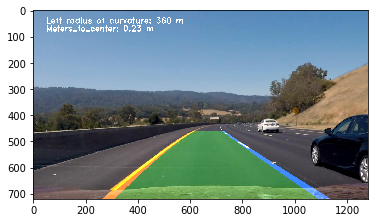

../test_images/challenge_1.jpg


In [41]:
# fit centers of boxes to polinomial of second degree
lane_y =range(0, warped.shape[0])
# box centers
result_y = np.arange(warped.shape[0]-(window_height/2), 0, -window_height)
#left line
left_fit = np.polyfit(result_y, leftx, 2)
left_fitx = np.array(left_fit[0]*lane_y*lane_y + left_fit[1]*lane_y + left_fit[2], np.int32)
#right line
right_fit = np.polyfit(result_y, rightx, 2)
right_fitx = np.array(right_fit[0]*lane_y*lane_y + right_fit[1]*lane_y + right_fit[2], np.int32)

#making line thicker so it gets drawn better
left_line = np.array(list(zip(np.concatenate((left_fitx-window_width/2, left_fitx[::-1]+window_width/2), axis=0), np.concatenate((lane_y, lane_y[::-1]), axis=0))), np.int32)
right_line = np.array(list(zip(np.concatenate((right_fitx-window_width/2, right_fitx[::-1]+window_width/2), axis=0), np.concatenate((lane_y, lane_y[::-1]), axis=0))), np.int32)

lanes = np.zeros_like(image)
inbetween_lanes = np.zeros_like(image)
cv2.fillPoly(lanes, [left_line], color=[200,0,0])
cv2.fillPoly(lanes, [right_line], color=[0,0,200])

#points = np.concatenate((left_line, right_line))
points_left = np.array([np.transpose(np.vstack([left_fitx, lane_y]))])
points_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, lane_y])))])
points = np.hstack((points_left, points_right))

cv2.fillPoly(inbetween_lanes, [points], color=(0, 255, 0))
cv2.fillPoly(inbetween_lanes, [left_line], color=(0, 255, 0))
cv2.fillPoly(inbetween_lanes, [right_line], color=(0, 255, 0))

plt.imshow(lanes)
plt.show()

lanes_wraped=unwarp(lanes,src, dst )
inbetween_lanes_warped = unwarp(inbetween_lanes,src, dst )

image_with_lines = cv2.addWeighted(image, 1.0, inbetween_lanes_warped, 0.3, 0.0)
image_with_lines_road = cv2.addWeighted(image_with_lines, 1.0, lanes_wraped, 1.0, 0.0)
plt.imshow(image_with_lines_road)
plt.show()

#calculate curvature radius by formular based on polynomial coefficients, take left turn
left_fit_x_r= np.array(left_fitx, np.float32)*curve_centers.meters_pp_x
left_fit_y_r= np.array(lane_y, np.float32)*curve_centers.meters_pp_y
polynomila_fit_real = np.polyfit(left_fit_y_r, left_fit_x_r, 2)
print(polynomila_fit_real)
left_curverad = ((1 + (2*polynomila_fit_real[0]*lane_y[-1]*curve_centers.meters_pp_y + polynomila_fit_real[1])**2)**1.5) / np.absolute(2*polynomila_fit_real[0])

print(left_curverad)
font = cv2.FONT_HERSHEY_DUPLEX
font_color = (255, 255, 255)
font_scale = 1
font_thickness = 2
#Calculating difference from center, assuming tthe middle of the picture should be the center
meters_to_center= ( (left_fitx[-1] + right_fitx[-1]) /2 - warped.shape[1]/2)*curve_centers.meters_pp_x
cv2.putText(image_with_lines_road, 'Left radius of curvature: %d m' % (round(left_curverad)), (50,50), font, font_scale, font_color, font_thickness)
cv2.putText(image_with_lines_road, 'Meters_to_center: %1.2f m' % (meters_to_center), (50,80), font, font_scale, font_color, font_thickness)


plt.imshow(image_with_lines_road)
plt.show()
print(image_name)


    

In [42]:
class Line():
    def __init__(self, n = 2):
        # was the line detected in the last iteration?
        self.detected = False 
        self.n = n
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        
    def get_polyfit(self, result_y) :
        if (len(self.recent_xfitted)> (self.n + 1)) :
            self.recent_xfitted.pop(0)
        x_avg = np.mean(self.recent_xfitted, axis=0)
        poly_fit = np.polyfit(result_y, x_avg, 2)
        return poly_fit


In [16]:

def get_final_image(image_input, warped,leftx, rightx, curve_centers, window_height, window_width,src_points,dest_points, right_line, left_line ):
    # fit centers of boxes to polinomial of second degree
    lane_y =range(0, warped.shape[0])
    # box centers
    result_y = np.arange(warped.shape[0]-(window_height/2), 0, -window_height)
    #left line
    
    #left_fit = np.polyfit(result_y, leftx, 2)
    left_fit = left_line.get_polyfit(result_y)
    
    
    left_fitx = np.array(left_fit[0]*lane_y*lane_y + left_fit[1]*lane_y + left_fit[2], np.int32)
    #right line
    #right_fit = np.polyfit(result_y, rightx, 2)
    right_fit= right_line.get_polyfit(result_y)
    
    
    right_fitx = np.array(right_fit[0]*lane_y*lane_y + right_fit[1]*lane_y + right_fit[2], np.int32)

    #making line thicker so it gets drawn better
    left_line = np.array(list(zip(np.concatenate((left_fitx-window_width/2, left_fitx[::-1]+window_width/2), axis=0), np.concatenate((lane_y, lane_y[::-1]), axis=0))), np.int32)
    right_line = np.array(list(zip(np.concatenate((right_fitx-window_width/2, right_fitx[::-1]+window_width/2), axis=0), np.concatenate((lane_y, lane_y[::-1]), axis=0))), np.int32)

    lanes = np.zeros_like(image_input)
    inbetween_lanes = np.zeros_like(image_input)
    cv2.fillPoly(lanes, [left_line], color=[200,0,0])
    cv2.fillPoly(lanes, [right_line], color=[0,0,200])

    #points = np.concatenate((left_line, right_line))
    points_left = np.array([np.transpose(np.vstack([left_fitx, lane_y]))])
    points_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, lane_y])))])
    points = np.hstack((points_left, points_right))

    cv2.fillPoly(inbetween_lanes, [points], color=(0, 255, 0))
    cv2.fillPoly(inbetween_lanes, [left_line], color=(0, 255, 0))
    cv2.fillPoly(inbetween_lanes, [right_line], color=(0, 255, 0))
    lanes_wraped=unwarp(lanes,src_points, dest_points )
    inbetween_lanes_warped = unwarp(inbetween_lanes,src_points, dest_points )

    image_with_lines = cv2.addWeighted(image_input, 1.0, inbetween_lanes_warped, 0.3, 0.0)
    image_with_lines_road = cv2.addWeighted(image_with_lines, 1.0, lanes_wraped, 1.0, 0.0)
    #calculate curvature radius by formular based on polynomial coefficients, take left turn
    left_fit_x_r= np.array(left_fitx, np.float32)*curve_centers.meters_pp_x
    left_fit_y_r= np.array(lane_y, np.float32)*curve_centers.meters_pp_y
    polynomila_fit_real = np.polyfit(left_fit_y_r, left_fit_x_r, 2)
    left_curverad = ((1 + (2*polynomila_fit_real[0]*lane_y[-1]*curve_centers.meters_pp_y + polynomila_fit_real[1])**2)**1.5) / np.absolute(2*polynomila_fit_real[0])
    font = cv2.FONT_HERSHEY_DUPLEX
    font_color = (255, 255, 255)
    font_scale = 1
    font_thickness = 2
    #Calculating difference from center, assuming tthe middle of the picture should be the center
    meters_to_center= ( (left_fitx[-1] + right_fitx[-1]) /2 - warped.shape[1]/2)*curve_centers.meters_pp_x
    cv2.putText(image_with_lines_road, 'Left radius of curvature: %d m' % (round(left_curverad)), (50,50), font, font_scale, font_color, font_thickness)
    cv2.putText(image_with_lines_road, 'Meters_to_center: %1.2f m' % (meters_to_center), (50,80), font, font_scale, font_color, font_thickness)
    return image_with_lines_road
    

In [17]:
#clip_0.save_frame('../test_images/challenge_2.jpg', t=23.89)

#image = cv2.imread('../test_images/challenge_2.jpg')
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#plt.imshow(image)
#plt.show()
print(image.shape)


(720, 1280, 3)


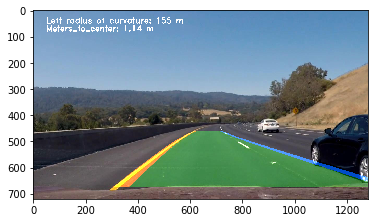

In [18]:


(cal_objpoints, cal_imgpoints) = get_camera_calibration_points()

right_line = Line()
left_line = Line()


 

def pipeline(init_image, right_line, left_line, src_points, dest_points):
    ##constants
    #src_points = np.float32([[179, 720], [1140, 720], [740, 460], [550, 460]])
    #dest_points = np.float32([[350, 720], [977, 720], [977, 0], [350, 0]]) 
    window_width=30
    window_height=80
    margin=25
    meters_pp_y = 3/107#10/720 
    meters_pp_x = 3.7/380#657#4/380
    #first undistort 
    undistorted=undistort(init_image, cal_objpoints, cal_imgpoints)  
    masked_image= color_and_gradient_filter(undistorted, ksize = 15)
    warped = warp(masked_image,src_points, dest_points)
    (leftx, rightx, curve_centers) = get_window_centers(warped)
    
    #update lines
    right_line.recent_xfitted.append(rightx)
    right_line.allx = rightx
    left_line.recent_xfitted.append(leftx)
    right_line.allx = leftx
    
    final_image = get_final_image(init_image, warped, leftx, rightx, curve_centers, window_height,window_width,
                                 src_points=src_points,dest_points=dest_points,
                                 right_line=right_line, left_line=left_line)
    return final_image

plt.imshow(pipeline(image, right_line, left_line, src, dst))
plt.show()



../test_images/challenge_1.jpg


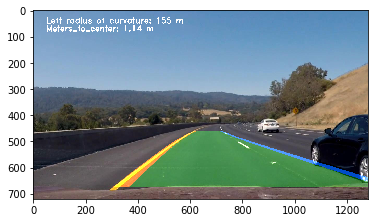

../test_images/challenge_2.jpg


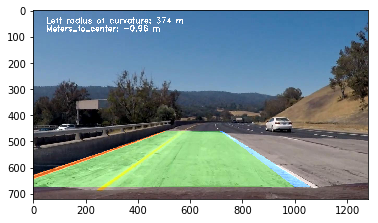

../test_images/challenge_3.jpg


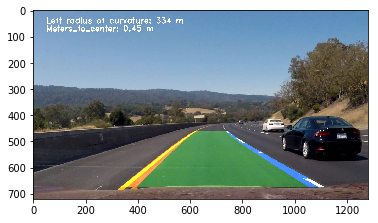

../test_images/straight_lines1.jpg


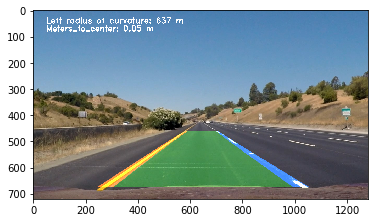

../test_images/straight_lines2.jpg


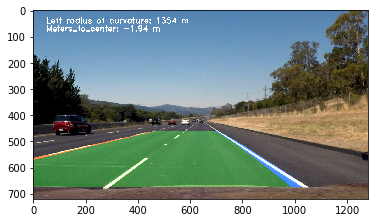

../test_images/test1.jpg


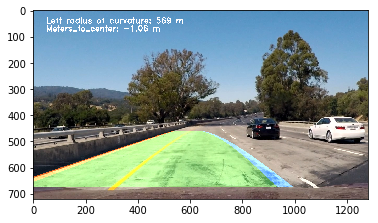

../test_images/test2.jpg


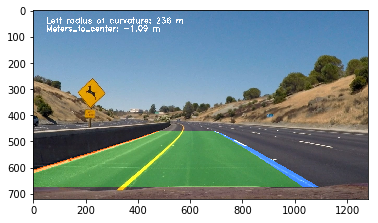

../test_images/test3.jpg


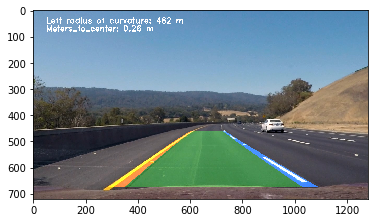

../test_images/test4.jpg


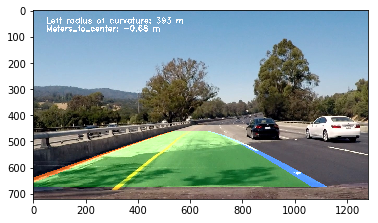

../test_images/test5.jpg


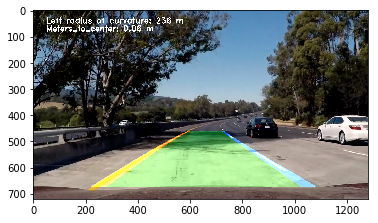

../test_images/test6.jpg


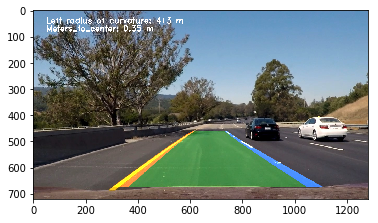

In [19]:

images = glob.glob('../test_images/*.jpg')
for fname in images:
    img = cv2.imread(fname)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    right_line = Line()
    left_line = Line()
    decorated= pipeline(img, right_line, left_line, src, dst)
    print(fname)
    plt.imshow(decorated)
    plt.show()


In [20]:
from moviepy.editor import VideoFileClip
output_video = 'result.mp4'
input_video = '../project_video.mp4'
right_line = Line(n=2)
left_line = Line(n=2)
clip_0 = VideoFileClip(input_video)
#result_video = clip_0.fl_image(lambda image : pipeline(image, right_line, left_line))
#%time result_video.write_videofile(output_video, audio=False)

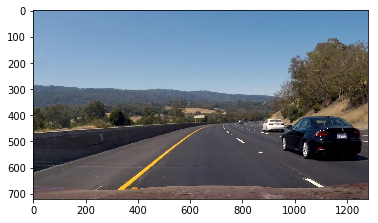

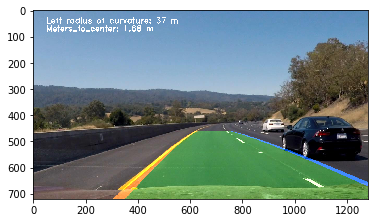

In [21]:
##saving challenging pictures
challenge_name = '../test_images/challenge_3.jpg'
clip_0.save_frame(challenge_name, t=30)
challenge_img = cv2.imread(challenge_name) #5
challenge_img = cv2.cvtColor(challenge_img, cv2.COLOR_BGR2RGB)
plt.imshow(challenge_img)
plt.show()
plt.imshow(pipeline(challenge_img,  right_line, left_line))
plt.show()